# RETO DE ANALÍTICA E INTELIGENCIA ARTIFICIAL PARA BIOCIENCIAS
Reto 2:	Clasificación del tratamiento del paciente: Combinando los datos de las imágenes médicas y de historia clínica, genere un modelo que permita clasificar el tratamiento para el paciente. 
Autor: Valery Castañeda

## Librerias

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import joblib
from pathlib import Path




## Carga de datos

In [71]:
df = pd.read_csv('data/brain_conditions_detailed_dataset.csv',  sep=';')
df.head()

,Case ID,Condition,Age,Sex,Clinical Note,Treatment
0,brain_glioma_0001,Brain Glioma,74,F,Patient is experiencing memory lapses and spee...,surgery
1,brain_glioma_0002,Brain Glioma,66,F,Patient is experiencing visual disturbances an...,chemotherapy
2,brain_glioma_0003,Brain Glioma,62,F,Patient is experiencing memory lapses and dizz...,surgery
3,brain_glioma_0004,Brain Glioma,24,M,Patient is experiencing memory lapses and pers...,surgery
4,brain_glioma_0005,Brain Glioma,69,M,Patient is experiencing dizziness and frequent...,surgery


## Análisis exploratorio

In [55]:
# Estadísticas generales
print(df['Age'].describe())
print(df['Sex'].value_counts())
print(df['Treatment'].value_counts())

count    6056.000000
mean       51.764531
std        19.619781
min        18.000000
25%        35.000000
50%        52.000000
75%        69.000000
max        85.000000
Name: Age, dtype: float64
Sex
F    3079
M    2977
Name: count, dtype: int64
Treatment
radiation therapy    1895
surgery              1848
chemotherapy         1174
close monitoring     1139
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribución de edad')

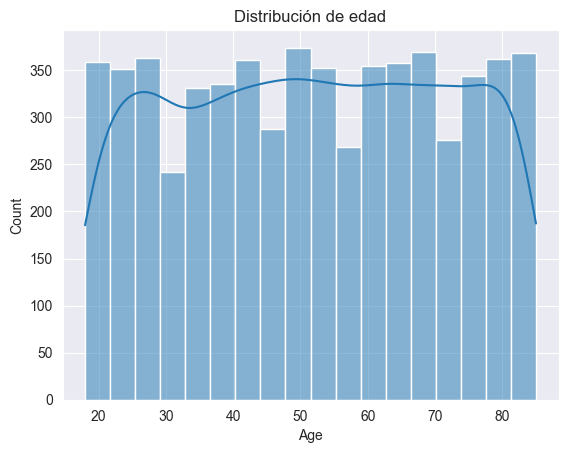

In [56]:
sns.histplot(df['Age'], kde=True)
plt.title('Distribución de edad')

In [57]:
print(f"Edad mínima: {df['Age'].min()}, máxima: {df['Age'].max()}")

Edad mínima: 18, máxima: 85


## Análisis descriptivo

<Axes: xlabel='Age', ylabel='Count'>

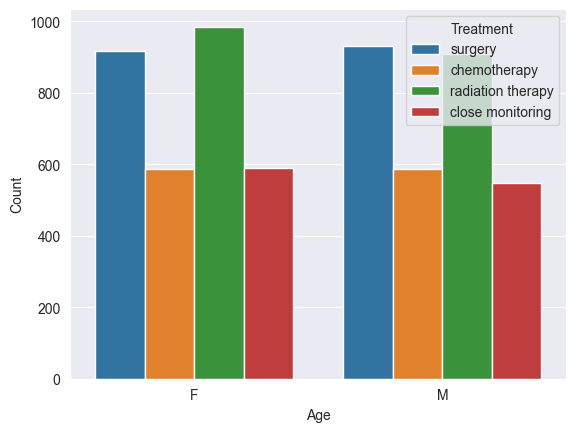

In [58]:
sns.histplot(df['Age'], kde=True)
sns.countplot(data=df, x='Sex', hue='Treatment')

<Axes: xlabel='Treatment', ylabel='Age'>

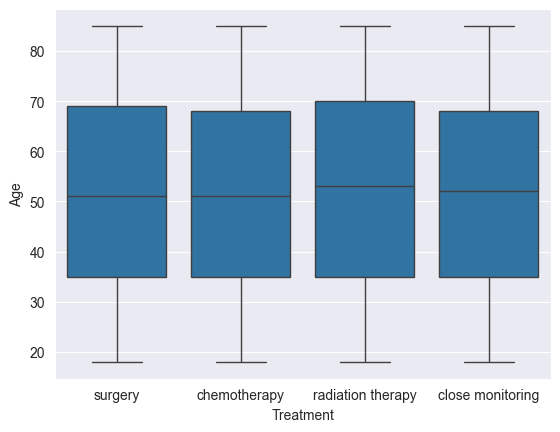

In [59]:
sns.boxplot(data=df, x='Treatment', y='Age')

In [60]:
pd.crosstab(df['Sex'], df['Treatment'], normalize='index')

Treatment,chemotherapy,close monitoring,radiation therapy,surgery
Sex,,,,
F,0.190646,0.191621,0.319909,0.297824
M,0.197178,0.184414,0.305677,0.312731


## Análisis inferencial

Hipótesis:

H₀ (nula): No hay diferencia en la edad media entre tratamientos.
H₁ (alternativa): Hay una diferencia en la edad media entre tratamientos.

Si p < 0.05: hay evidencia para rechazar H₀ → diferencia significativa.
Si p ≥ 0.05: no hay suficiente evidencia para rechazar H₀.

In [61]:
grupo_surgery = df[df['Treatment'] == 'surgery']['Age']
grupo_chemo = df[df['Treatment'] == 'chemotherapy']['Age']

t_stat, p_value = ttest_ind(grupo_surgery, grupo_chemo, equal_var=False)

print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")


T-statistic: 0.333, P-value: 0.739


In [62]:
tabla = pd.crosstab(df['Sex'], df['Treatment'])
chi2, p, dof, expected = chi2_contingency(tabla)

print(f"Chi²: {chi2:.3f}, p-valor: {p:.3f}")


Chi²: 2.833, p-valor: 0.418


## Preprocesamiento de texto

In [63]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # solo letras
    tokens = text.split()  # tokenización básica
    tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS]  # stopwords
    return ' '.join(tokens)

In [64]:
df['clean_note'] = df['Clinical Note'].apply(clean_text)

In [65]:
df['Sex'] = df['Sex'].map({'F': 0, 'M': 1})
scaler = MinMaxScaler()
df['Age_scaled'] = scaler.fit_transform(df[['Age']])

In [66]:
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(df['clean_note'])

In [67]:
X_tabular = df[['Age_scaled', 'Sex']].values
X = hstack([X_text, X_tabular])
y = df['Treatment']

## Modelamiento MultinomialNB

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [69]:
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

Reporte de Clasificación:
                   precision    recall  f1-score   support

     chemotherapy       0.30      0.79      0.44       236
 close monitoring       0.30      0.45      0.36       213
radiation therapy       0.31      0.13      0.19       385
          surgery       0.34      0.10      0.16       378

         accuracy                           0.31      1212
        macro avg       0.31      0.37      0.29      1212
     weighted avg       0.32      0.31      0.26      1212


## Modelamiento RandomForest

In [72]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # elimina signos y números
    tokens = text.split()
    tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS]
    return ' '.join(tokens)

df['clean_note'] = df['Clinical Note'].apply(clean_text)

df['Sex'] = df['Sex'].map({'F': 0, 'M': 1})
scaler = MinMaxScaler()
df['Age_scaled'] = scaler.fit_transform(df[['Age']])

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_text = vectorizer.fit_transform(df['clean_note'])

X_tabular = df[['Age_scaled', 'Sex']].values
X = hstack([X_text, X_tabular])

y = df['Treatment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))


Reporte de Clasificación:
                   precision    recall  f1-score   support

     chemotherapy       0.27      0.28      0.27       235
 close monitoring       0.28      0.27      0.27       228
radiation therapy       0.31      0.31      0.31       379
          surgery       0.31      0.31      0.31       370

         accuracy                           0.29      1212
        macro avg       0.29      0.29      0.29      1212
     weighted avg       0.29      0.29      0.29      1212


In [73]:

# Usar directorio actual
output_path = Path.cwd() / 'models' / 'modelo_random_forest_BrainTumorTreatment.pkl'
output_path.parent.mkdir(parents=True, exist_ok=True)  # crea la carpeta si no existe

joblib.dump(clf, output_path)
joblib.dump(vectorizer, Path.cwd() / 'models' / 'vectorizer.pkl')
joblib.dump(scaler,Path.cwd() / 'models' / 'scaler.pkl')

['/Users/valecaad/Documents/RetoConocimientoTecnico/models/scaler.pkl']

## Conclusiones

Al analizar el dataset se puede notar que los datos parecen estar equilibrados entre categorias, se puede decir que es data dummy, es necesario poblar la data con otras variables ademas del sexo y la edad que permitan diferenciar los tratamientos o incluso encontrar patrones en la data.
Se pueden aplicar otras tecnicas para agrupar los comentarios de los doctores, podriamos completar el dataset con variables como diagnostico, sintomas, duracion entre otras, se pueden usar otros modelos, como XGBoost que no logre utilizar por el computador donde lo estaba ejecutando, incluso si se tiene acceso a GPU permite robustecer aun mas los modelos. 